# Algorithm for Line finding

Steps for Line finding 
1.	Get image with clear lane lines. (after calibration, thresholding, perspective transformation)

2.	Divide image into half from middle, assuming car is in within lane. Left half image will have left lane and 
right half image will right lane. 

3.	Identify starting location of left lane in left half of image and right lane in right half of image. 
“Peak in Histogram” method is used. For this method only lower half image is used. 
Reason for using lower half image is that lower will have relatively straight vertical line. 
Which means if we sum across column, the column with highest sum will likely have lane on it, including starting point 
of the lane.  Highest sum before mid-point will be related to left lane, and mid will be related to right lane. 

To identify “peak” the “highest sum” we have used scipy.find_peaks_cwt.
This function use 1-D array as required input, we can also define width of peak in our case it will be width of lane. 
And distance between one peak and next peak to that peak, in our case it will be distance between left and right lane. 
Width of peak: 100    (this should cover the expected width of peaks of interest)
Distance between two peaks “max_distances”: 1000 
peak_indexes = find_peaks_cwt( x  ,[100], max_distances=[1000])
1000 is imperial value, based on visual assessment, see "Histogram : Location of right and Left Lane" in Task-4 below. 
 
After getting peaks indexes, next step will be which peak belong to left lane and which belong to right lane. 
For that we order maximum strength index.  To do that we first have to order indexes for that we use.
np.argsort ( - peak_indexes  )   “-“ used for descending order
First index will be for right, second index for left. 
That is if two index are found otherwise one previous index is used. 
 
4.	After identifying starting points, we will use “sliding window” technique identify lane across the image, moving 
bottom to top.

5.	We will use 2 order polynomial to draw a line across this predicted lane pixel points.  

6.	For error correction and removing outline pixels, 

    a.	For first frame, we will discard pixel as lane pixel, if pixel lane is more than 60 pixel away from 
    previous identified pixel. Reason being we are assuming lane will be relatively straight so angle between 
    current and previous prediction will be relatively less. Pixel is more than 60 we will use previous 
    predicted location. 

    b.	For following frames for treatment of error propagation, 
        i.	Adjust coefficient. For that we use the standard deviations. If deviation is more than 0.0005 
        we are using previous image frame coefficient.
 
        ii.	After image thresholding (with binary image mask) with we are making sure pixel count is more than 5 (to remove noise) (after filtering pixels with strength less 0.5) 

    c.	For smoothing we used a moving average filter, it smooths data by replacing each data point with the average of the neighboring data points defined within the span. This process is equivalent to lowpass filtering with the response of the smoothing given by the difference equation

    https://www.mathworks.com/help/curvefit/smoothing-data.html
    
    

What happens when left or right line is not detected for long or its missing from start. I added/subtracted 850       based on detected lane (right or left, less or more than 500). This technique kept lane relatively smooth than         before. See “challenge video” for this. see function get_polynomial_fit for implementation. 850 number came from   histogram analysis ( Step 4 in notebook) its average distance between left and right (see historgram in step 4).
If no edge was detected we set 150 for left and 1000 for right again based on histogram.  

# Limitation in project

Where its failing. Algorithm will fail if road is too much winding. It means in one direct when turning, you might have smaller road portion in front of you. Means you might be seeing road side edge. There is no point of drawing lane on it. see harder challenge video for this effect. One might thing road curving angling might help but this situation could even arise when you reach dead end of road or you have T intersection, in front of you is road edge . this is no point of doing image processing on it.  What might help is that we have to keep track of road itself not only lane line on it. we could train our processing pipeline color of road both day and night. Accurate Detection of road edge might help a lot. 

# Image processing Steps

    1. Correct Image
    2. Corp region of interest
    3. Do Perspective transformation
    4. Apply color filter (white and yellow) (on Perspective transformation)
    5. Apply Sobel filter (on Perspective transformation)
    6. Combined filter (color and sobel filtered image)

# Import PKG

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
import gzip
import glob

from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Import Images for calibration

Count of images  20
Shape of image  (720, 1280, 3)


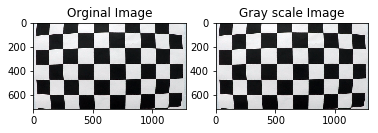

In [2]:
cimages = glob.glob("camera_cal/calibration*.jpg")
img0 = cv2.imread(cimages[0])
img_size = (img0.shape[1], img0.shape[0])

plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(img0)
plt.title('Orginal Image')
plt.subplot(1,2,2)
plt.imshow(img0, cmap='gray')
plt.title('Gray scale Image')


print("Count of images ",len(cimages))
print("Shape of image ", img0.shape)

# Task 1 : Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

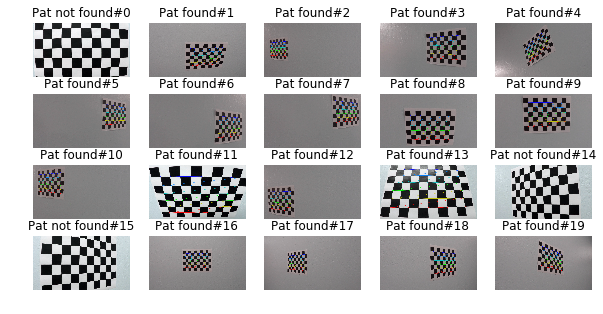

In [3]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Initialise image and object point arrays
objpoints = []
imgpoints = []

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

plt.figure(figsize = (10,5))
plt.axis('off')
for i in range(len(cimages)):
    # Read in image
    fname = cimages[i]
    cimg = cv2.imread(fname)
    
    # Convert to grayscale
    cgray = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners 
    # parameters: (image, chessboard dims, param for any flags)
    # returns: the corner points and retval which will be True if pattern is obtained. 
    # These corners will be placed in an order (from left-to-right, top-to-bottom)
    ret, corners = cv2.findChessboardCorners(cgray, (nx, ny), None)

    plt.subplot(4,5,i+1)
    # If found, draw corners
    if ret == True:       
        # Ddd object points & image points
        
        corners2=cv2.cornerSubPix(cgray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(cimg, (nx, ny), corners2, ret)
        plt.title('Pat found#' + str(i) )
        plt.imshow(cimg)
        #plt.axis('off')
    else:
        plt.title('Pat not found#' + str(i) )
        plt.imshow(cimg)
    plt.axis('off')
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
data = [mtx,dist]
pickle.dump( data, open( "camera_calibration.pkl", "wb" ) )

# Task 2 : Apply the distortion correction to the raw image

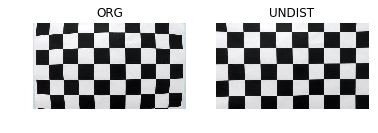

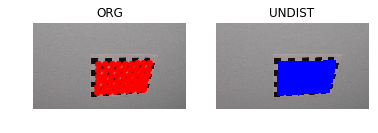

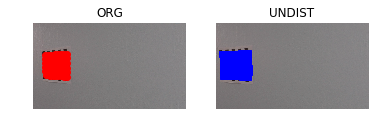

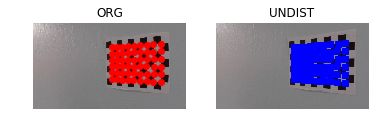

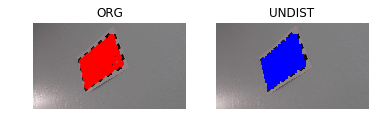

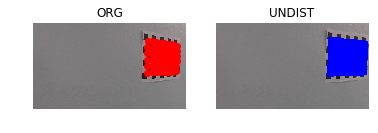

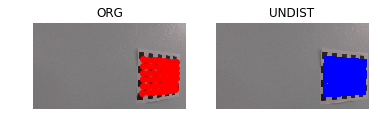

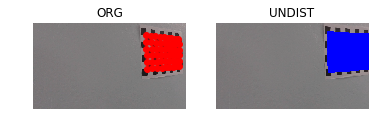

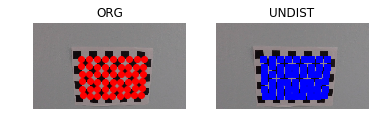

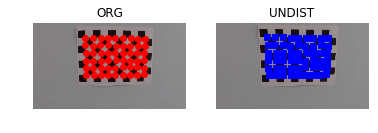

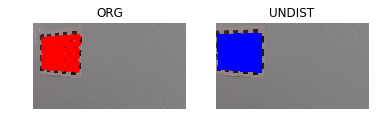

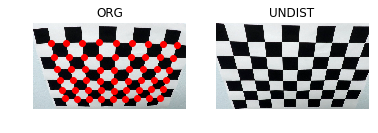

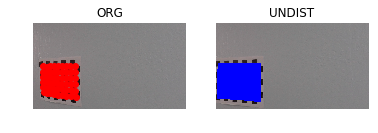

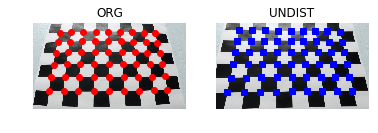

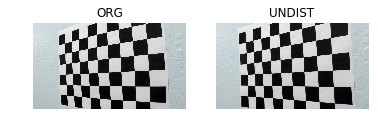

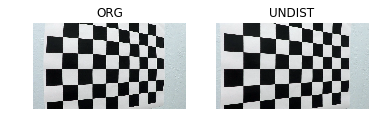

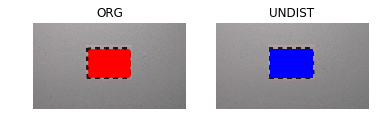

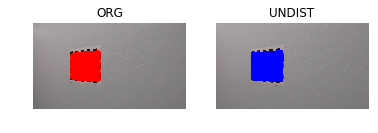

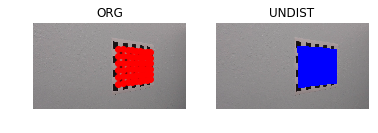

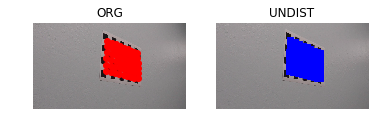

In [4]:
with open('camera_calibration.pkl', 'rb') as f:
    data2 = pickle.load(f)
    mtx= data2[0]
    dist=data2[1]


    
for i in range(len(cimages)):
    # Read in image
    fname = cimages[i]
    cimg2 = cv2.imread(fname)  
    
    undist = cv2.undistort(cimg2, mtx, dist, None, mtx)
    plt.subplot(1,2,1)

    cgray = cv2.cvtColor(cimg2, cv2.COLOR_BGR2GRAY)
    ret,    corners    = cv2.findChessboardCorners(cgray,   (nx, ny), None)
    ret_ud, corners_ud = cv2.findChessboardCorners(undist, (nx, ny), None)
 
    if ret == True:
        for i_c in range(len(corners)):
            plt.plot(corners[i_c][0][0],corners[i_c][0][1],'ro')
    
    plt.title('ORG')
    plt.imshow(cimg2)
    plt.axis('off')   
    
    
    plt.subplot(1,2,2)
    plt.title('UNDIST')
    plt.imshow(undist)
    
    if ret_ud == True:
        for i_c in range(len(corners_ud)):
            plt.plot(corners_ud[i_c][0][0],corners_ud[i_c][0][1],'bs')
    plt.axis('off');
    plt.show();

# Task 3 : Use color transforms, gradients, etc., to create a thresholded binary image.

Supporting Functions


In [5]:
def image_undistort(image, mtx, dist):
    return cv2.undistort(image,mtx,dist,None,mtx)

def image_smooth(image,kernel_size):
    return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)


def threshold_sobel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return sobel_filter(gray, orient, sobel_kernel, thresh)

def sobel_filter(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        derivative = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    else:
        print("Error: orient must be either x or y.")
    
    # 3) Take the absolute value of the derivative or gradient
    abs_derivative = np.absolute(derivative)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # So there are 1s where #s are within our thresholds and 0s otherwise.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary
 

def threshold_Magnitude(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 6) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 7) Return this mask as your binary_output image
    return mag_binary


def threshold_Direction(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Define a function that applies Sobel x and y, 
    # then computes the direction of the gradient
    # and applies a threshold.

    # An orientation of 0 implies a horizontal line 
    # An orientations of +/− pi/2 imply vertical lines. 
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary


def threshold_L_channel(img, thresh=(50, 255)):    
    #Sobel gradient function = find “Find Edges” function, 
    #calculates the derivative of brightness in the horizontal and vertical directions 
    #These two derivatives are then combined to determine the magnitude of the local change in brightness, 
    #and the resulting value highlights the edges with lines. 
    #Since this is a very localized operator, it generally highlights the finest detail,
    #but it responds differently to edges in bright and dark regions of the image.    
    #https://www.quora.com/Why-can-Sobel-operator-be-only-applied-to-grayscale-images
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    #Get L Channel 
    l_channel = hsv[:,:,1]
    
    #lightness
    #img_abs_x = threshold_sobel(l_channel, 'x')
    #img_abs_y = threshold_sobel(l_channel, 'y')
    #mask_L  = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    mask_L = np.zeros_like(scaled_sobel)
    mask_L[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mask_L
    

def threshold_S_channel(img, thresh=(0, 255)):    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    #Get S Channel 
    s_channel = hsv[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def get_mask_required_color(image):
    image_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
    hsv_yellow_low = np.array([0,100,100])
    hsv_yellow_high = np.array([50,255,255])
    
    hsv_white_low = np.array([ 20, 0 , 180])
    hsv_white_high = np.array([255,80,255])
    
    mask_yellow = cv2.inRange(image_hsv,hsv_yellow_low, hsv_yellow_high)
    mask_white = cv2.inRange(image_hsv,hsv_white_low, hsv_white_high)
    
    return cv2.bitwise_or(mask_yellow,mask_white),mask_yellow,mask_white


def mask_image(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def image_warp(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv


def image_perspective_transform(image):
    img_size = image.shape
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    mid_point = np.uint(img_size[1]/2)
    
    corner_top_left = mid_point - .25*mid_point
    corner_top_right = mid_point + .25*mid_point
    corner_bottom_left = mid_point - 1*mid_point   # = 0
    corner_bottom_right = mid_point + 1*mid_point  # = img_size[1]
    
    src = np.float32(
        [
            [corner_bottom_left ,hb_window],
            [corner_bottom_right,hb_window],
            [corner_top_right   ,ht_window],
            [corner_top_left    ,ht_window]
        ])
    
    dst = np.float32(
        [
            [0,img_size[0]],
            [img_size[1],img_size[0]],
            [img_size[1],0],
            [0,0]
        ])
    
    warped,M_warp,Minv_warp = image_warp(image,src,dst,(img_size[1],img_size[0])) 
    return warped,M_warp,Minv_warp,src,dst





def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n -1:] /n



def get_mask_sobel_gradien(image):
    #Sobel gradient function = find “Find Edges” function, 
    #calculates the derivative of brightness in the horizontal and vertical directions 
    #These two derivatives are then combined to determine the magnitude of the local change in brightness, 
    #and the resulting value highlights the edges with lines. 
    #Since this is a very localized operator, it generally highlights the finest detail,
    #but it responds differently to edges in bright and dark regions of the image.
    
    #https://www.quora.com/Why-can-Sobel-operator-be-only-applied-to-grayscale-images
        
    #convert to HLS Channels
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    
    #Ignoring H channel 
    
    #Get L Channel 
    #lightness
    img_L_channel = image_HLS[:,:,1]
    img_abs_x = sobel_filter(img_L_channel, 'x',5, thresh=(50, 225))
    img_abs_y = sobel_filter(img_L_channel, 'y',5, thresh=(50, 225))
    mask_L  = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    #Get S Channel 
    #The saturation of a color is determined by a combination of light intensity 
    #and how much it is distributed across the spectrum of different wavelengths. 
    img_S_channel = image_HLS[:,:,2]
    img_abs_x = sobel_filter(img_S_channel, 'x',5, thresh=(50, 225))
    img_abs_y = sobel_filter(img_S_channel, 'y',5, thresh=(50, 225))
    mask_S  = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    mask = cv2.bitwise_or(mask_L,mask_S)
    mask = image_smooth(mask,25)
    
    return mask    

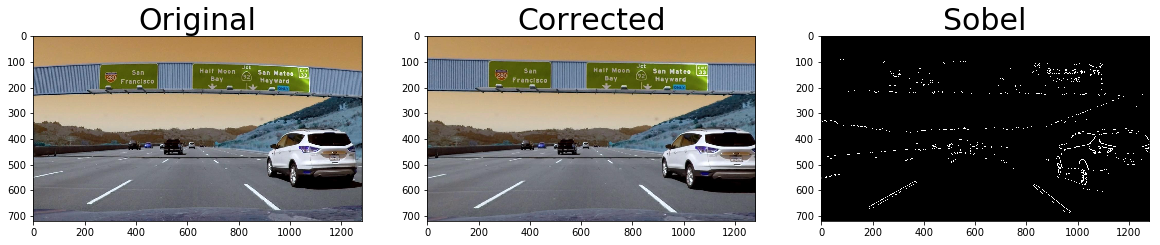

In [6]:
# Sobel kernel size
ksize = 3 

img3 = cv2.imread("quiz.png")
corrected_img = image_undistort(img3, mtx, dist)

#threshold_L_channel(img, thresh=(50, 255))
    
gradx = threshold_sobel(corrected_img, orient='x',sobel_kernel=ksize,  thresh=(150, 255))
grady = threshold_sobel(corrected_img, orient='y',sobel_kernel=ksize,  thresh=(70, 200))
mag_binary = threshold_Magnitude(corrected_img, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = threshold_Direction(corrected_img, sobel_kernel=ksize, thresh=(0.1, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Visualize undistortion
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img3)
ax1.set_title('Original', fontsize=30)
output_file_name = os.path.join('output_images/task3_1_Original_img.jpg')
mpimg.imsave(output_file_name,img3)

ax2.imshow(corrected_img)
ax2.set_title('Corrected', fontsize=30)
output_file_name = os.path.join('output_images/task3_2_Corrected_img.jpg')
mpimg.imsave(output_file_name,corrected_img)

ax3.imshow(combined, cmap='gray')
ax3.set_title('Sobel', fontsize=30)
output_file_name = os.path.join('output_images/task3_3_Sobel_Corrected_img.jpg')
mpimg.imsave(output_file_name,combined)

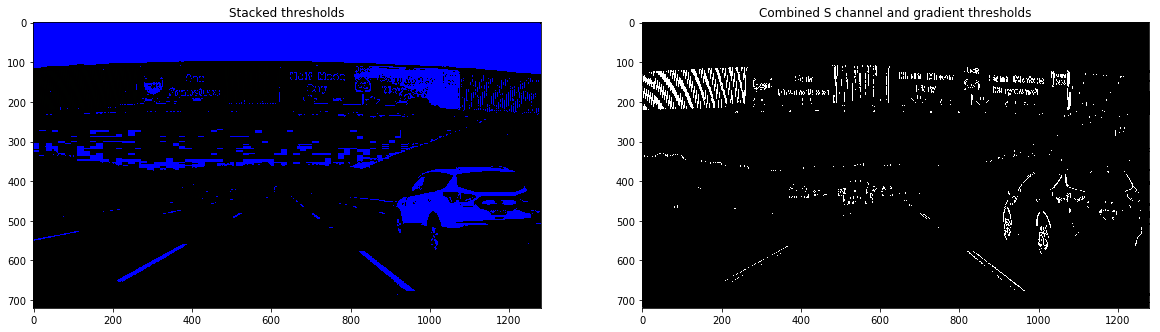

In [7]:
sxbinary = threshold_L_channel(img3, thresh=(50, 255))
s_binary,mask_yellow,mask_white = get_mask_required_color(img3)

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
output_file_name = os.path.join('output_images/task3_4_Stacked_Threshold_img.jpg')
mpimg.imsave(output_file_name,color_binary)


ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
output_file_name = os.path.join('output_images/task3_5_Schannel_&_Gradient_Threshold_img.jpg')
mpimg.imsave(output_file_name,combined_binary)

# Task 4: Apply a perspective transform and (then Apply color and sobel filter)

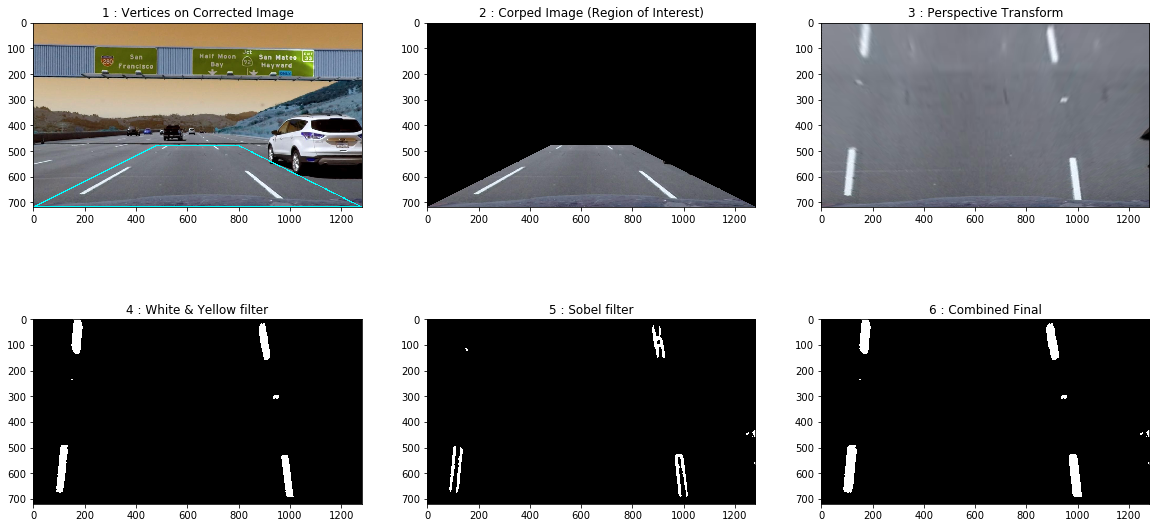

In [8]:
img_T4 = cv2.imread("quiz.png")
img_T4 = image_undistort(img_T4, mtx, dist)

img_T4_1 = np.copy(img_T4)
img_T4_2 = np.copy(img_T4)

imshape = img_T4_2.shape 
vertices = np.array([[(0,imshape[0]),(480, 480), (800, 480), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = mask_image(img_T4_2, vertices)
cv2.polylines(img_T4_1,vertices,True,(0,255,255),3)

warped,M,Minv,src,dst = image_perspective_transform(masked_image)
warped = image_smooth(warped,1)

mask_color,mask_yellow,mask_white = get_mask_required_color(warped) 
mask_sobel = get_mask_sobel_gradien(warped)     
   
#combine mask
mask = np.zeros_like(mask_sobel)
mask [(mask_color>=.5)|(mask_sobel>=.5)]=1
    

# Plotting thresholded images
f, ((ax1, ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(20,10))

ax1.set_title("1 : Vertices on Corrected Image")
ax1.imshow(img_T4_1)
output_file_name = os.path.join('output_images/task4_1_Vertices_on_corrected_img.jpg')
mpimg.imsave(output_file_name,img_T4_1)

ax2.set_title("2 : Corped Image (Region of Interest)")
ax2.imshow(masked_image, cmap="gray")
output_file_name = os.path.join('output_images/task4_2_Corped_img.jpg')
mpimg.imsave(output_file_name,masked_image)

ax3.set_title("3 : Perspective Transform")
ax3.imshow(warped, cmap="gray")
output_file_name = os.path.join('output_images/task4_3_Perspective_Transform_img.jpg')
mpimg.imsave(output_file_name,warped)

ax4.set_title("4 : White & Yellow filter")
ax4.imshow(mask_color, cmap="gray")
output_file_name = os.path.join('output_images/task4_4_WhiteYellow_filter_img.jpg')
mpimg.imsave(output_file_name,mask_color)

ax5.set_title("5 : Sobel filter")
ax5.imshow(mask_sobel, cmap="gray")
output_file_name = os.path.join('output_images/task4_5_Sobel_filter_img.jpg')
mpimg.imsave(output_file_name,mask_sobel)

ax6.set_title("6 : Combined Final")
ax6.imshow(mask, cmap="gray")
output_file_name = os.path.join('output_images/task4_6_Combined_Final_img.jpg')
mpimg.imsave(output_file_name,mask)

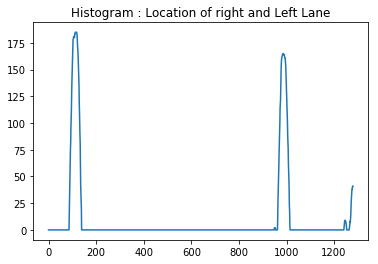

In [9]:
import matplotlib
plt.title("Histogram : Location of right and Left Lane")
histogram = np.sum(mask[int(mask.shape[0]/2):,:],axis=0)
plt.plot(histogram)

output_file_name = os.path.join('output_images/task4_4_Histogram.png')
plt.savefig(output_file_name) 

# Task 5 : Image pipeline : Detect lane pixels and fit to find lane boundary.

In [10]:
def get_polynomial_fit(img,kernel_size,window_sz):
    
    # This function gets the initial mask
    
    img = image_smooth(img,kernel_size)
    img_size = np.shape(img)
    mov_filtsize = img_size[1]/50.
    mean_ln = np.mean(img[int(img_size[0]/2):,:],axis=0)
    
    indexes = find_peaks_cwt(mean_ln,[100], max_distances=[1000])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    if len(indexes)>1.5:
        ind_peakR = indexes[ind_sorted[0]]
        ind_peakL = indexes[ind_sorted[1]]
    elif len(indexes)==1:
        if(indexes[ind_sorted[0]]<500):
            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = ind_peakR + 850
        else:
            ind_peakL = indexes[ind_sorted[0]]
            ind_peakR = ind_peakL - 850
    else: 
        ind_peakL = 1000
        ind_peakR = 150
        
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_sz
    ind_max_L = ind_peakL+window_sz

    ind_min_R = ind_peakR-window_sz
    ind_max_R = ind_peakR+window_sz

    mask_L_i = np.zeros_like(img)
    mask_R_i = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    
    # Split image into 8 parts and compute histogram on each part    
    for i in range(8):
        img_y1 = img_size[0]-int((img_size[0]*i)/8)
        img_y2 = img_size[0]-int((img_size[0]*(i+1))/8)
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[1000])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
        # If no pixels are found, use previous ones. 
            if len(indexes)==1:
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
            
        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL-ind_peakL_prev)>=60:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=60:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L_i[img_y2:img_y1,ind_peakL-window_sz:ind_peakL+window_sz] = 1.
        mask_R_i[img_y2:img_y1,ind_peakR-window_sz:ind_peakR+window_sz] = 1.
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L_i,mask_R_i



def get_mask_poly(img,poly_fit,window_sz):
    
    # This function returns masks for points used in computing polynomial fit. 
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0]-int((img_size[0]*i)/8)
        img_y2 = img_size[0]-int((img_size[0]*(i+1))/8)

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = int(np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2]))
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_sz:poly_pt+window_sz] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)

def get_val(y,pol_a):
    # Returns value of a quadratic polynomial 
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

def draw_pw_lines(img,pts,color):
    # This function draws lines connecting 10 points along the polynomial
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        
def get_curvature(pol_a,y_pt,scale=1):
    # Returns curvature of a quadratic
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt*scale+B)**2)**1.5/np.absolute(2*A)
    return R_curve

In [11]:
def resize(src, ratio, interpolation=cv2.INTER_AREA):
    return cv2.resize(src=src, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=interpolation) 

def addPip(pipImage, dstImage, pipAlpha=0.5, pipResizeRatio=0.3, origin=(20, 20)):
    """
    Adding small Picture-in-picture binary bird-eye projection 
    :param pipImage: original binary bird-eye projection with search areas 
    :param dstImage: destination color image (assumed undistorted)
    :param pipAlpha: pip alpha
    :param pipResizeRatio: pip scale
    :param origin: coordinates of upper-left corner of small picture
    :return: color image with P-i-P embedded
    """
    smallPip = resize(src=pipImage, ratio=pipResizeRatio)
    pipHeight = smallPip.shape[0]
    pipWidth = smallPip.shape[1]
    backGround = dstImage[origin[1]:origin[1] + pipHeight, origin[0]:origin[0] + pipWidth]

    blend = np.round(backGround * (1 - pipAlpha), 0) + np.round(smallPip * pipAlpha, 0)
    blend = np.minimum(blend, 255)

    dstImage[origin[1]:origin[1] + pipHeight, origin[0]:origin[0] + pipWidth] = blend

    return dstImage

In [12]:
def pipeline(image, kernel_size, window_size, mtx_camera , dist_camera):
    
    global left_fit_prev   
    global right_fit_prev
    global col_R_prev
    global col_L_prev
    global set_prev
   
    global left_fit_mask
    global right_fit_mask
    
    #ym_per_pix = 30/(image.shape[0]/2) 
    # we took lower half of image thats why divinding by two. 
    #xm_per_pix = 3.7/(image.shape[1]/2) 
    # Assumming Car is in center of frame / lane is in center of frame / width of lane is about half of width of frame.
    
  

    img_size = np.shape(image)
    
    image_undistorted = image_undistort(image, mtx_camera , dist_camera)
    image_undistorted_smoothed  = image_smooth(image_undistorted, kernel_size)
    warped,M_warp,Minv_warp,src,dst  = image_perspective_transform(image_undistorted_smoothed)
    
    mask_color,mask_yellow,mask_white = get_mask_required_color(warped) 
    mask_sobel = get_mask_sobel_gradien(warped)     
   
    #combine mask
    mask = np.zeros_like(mask_sobel)
    mask [(mask_color>=.5)|(mask_sobel>=.5)]=1
    
    #get Left and Right fit for second order polynomial    
    if set_prev == 0:
        mask  = image_smooth(mask, 5)
        left_fit_mask, right_fit_mask = get_polynomial_fit(mask, kernel_size, 40)     
        
        
    #intialize left and right color 
    col_R = (255,255,255) #white
    col_L = (255,255,255) #white
    
    
    #compute polynomial fit for left
    img_L = cv2.bitwise_and(mask,left_fit_mask)    
    vals = np.argwhere(img_L>.5)
    if len(vals)<5:
        left_fit = left_fit_prev
        col_L = col_L_prev
    else: 
        left_fit = np.polyfit(vals.T[0], vals.T[1], 2)
        if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:#zara
                  col_L = (255,255,0) #yellow color
                  
                    
                    
    #compute polynomial fit for right
    img_R = cv2.bitwise_and(mask,right_fit_mask)    
    vals = np.argwhere(img_R>.5)
    if len(vals)<5:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else: 
        right_fit = np.polyfit(vals.T[0], vals.T[1], 2)
        if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
                  col_R = (255,255,0) #yellow color
                
    
    
    ## assign initial mask, and save coefficient values for next frame            
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit 
    
    
    
    # Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2) 
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        
    # Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2) 
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit =  left_fit_prev
        col_L = col_L_prev
    else:
        left_fit =  .05* left_fit+.95* left_fit_prev
        
        
        
        
    
    
    ## Compute lane mask for future frame 
    left_fit_mask,left_pts,img_pts = get_mask_poly(mask,left_fit,window_size)
    right_fit_mask,right_pts,img_pts = get_mask_poly(mask,right_fit,window_size)
     
        
    ## Compute lanes        
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    

    ## Compute intercepts
    left_bot = get_val(img_size[0]-1,left_fit)
    right_bot = get_val(img_size[0]-1,right_fit)
    
    ## lane center zara
    laneWidth = right_bot - left_bot
    xm_per_pix = 3.7/laneWidth
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    ## Compute lane offset
    #dist_offset = val_center - img_size[1]/2
    #dist_offset = np.round(dist_offset/2.81362,2)
    #str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'    
    dist_offset = ((img_size[1]/2)-val_center)*xm_per_pix
    str_offset = 'Lane Offset: ' + str(dist_offset) + ' m.'
    
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
        

    # Draw the lane onto the warped blank image    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    ym_per_pix = 30/(image.shape[0]) 
    
    # Curvature Data
    left_curve = get_curvature(left_fit,img_size[0]-1,ym_per_pix)
    Right_curve = get_curvature(right_fit,img_size[0]-1,ym_per_pix)
    curvature = (left_curve+Right_curve)/2
    ##str_curv = 'Curvature: Right = ' + str(np.round(Right_curve,2)) + 'm, Left = ' + str(np.round(left_curve,2)) +'m'
    str_curv = 'Curvature = ' + str(10*np.round(curvature/100,1)) + 'm'   
    cv2.putText(result, str_curv, (30, 60+240), cv2.FONT_HERSHEY_COMPLEX, 1, (255,0,0), 2)
    cv2.putText(result, str_offset, (30, 90+240), cv2.FONT_HERSHEY_COMPLEX, 1, (255,0,0), 2)
    

    # perspective_transform & Sobel Mask
    iwarped,_,_,_,_ = image_perspective_transform(result)
    imask_sobel = get_mask_sobel_gradien(iwarped)    
    arr = 255*cv2.bitwise_and(mask_sobel,mask_sobel,mask=left_fit_mask+right_fit_mask)
    imask_sobel_img = np.stack((arr,arr,arr), axis=2)    
    addPip(iwarped, result, .7, .35,(20, 20))
    addPip(imask_sobel_img , result, .7, .35,(650, 20))   
    
    #repostioning by calculateing new mask (after 10 missing frames)
    if dist_offset>10:
        left_fit_mask, right_fit_mask = get_polynomial_fit(mask, kernel_size, 40) #zara
        
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L  
       
    
    return result  

In [13]:
def process_image(imgp): 
    with open('camera_calibration.pkl', 'rb') as f:
        data2 = pickle.load(f)
        mtx= data2[0]
        dist=data2[1]
    
    #global set_prev
    #set_prev=0 
    
    #kernel size of filter
    kernel_size =5
    #sliding window size 
    window_size =60
    
    result = pipeline(imgp,kernel_size,window_size,mtx,dist)
    #print(result.shape)
    return result

# Test Image pipeline on single Image

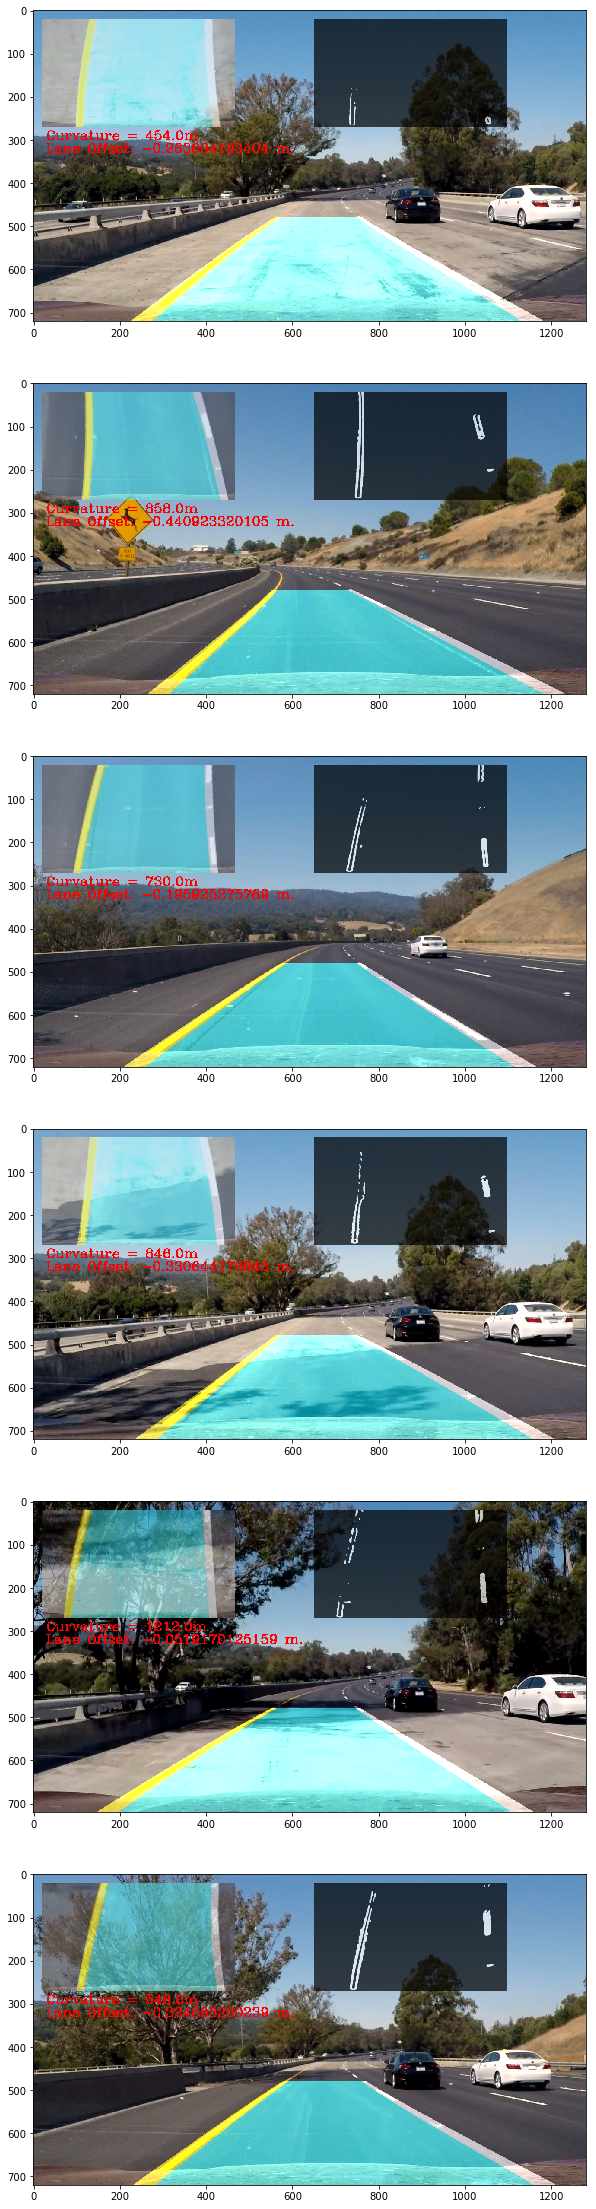

In [14]:
mpl_fig = plt.figure(figsize=(100,40))

set_prev=0
plt.subplot(611)
out_image1 = process_image(mpimg.imread('test_images/test1.jpg'))
plt.imshow(out_image1)
output_file_name = os.path.join('output_images/task5_pipeline_test1.jpg')
mpimg.imsave(output_file_name,out_image1)


set_prev=0
plt.subplot(612)
out_image2 = process_image(mpimg.imread('test_images/test2.jpg'))
plt.imshow(out_image2)
output_file_name = os.path.join('output_images/task5_pipeline_test2.jpg')
mpimg.imsave(output_file_name,out_image2)

set_prev=0
plt.subplot(613)
out_image3 = process_image(mpimg.imread('test_images/test3.jpg'))
plt.imshow(out_image3)
output_file_name = os.path.join('output_images/task5_pipeline_test3.jpg')
mpimg.imsave(output_file_name,out_image3)

set_prev=0
plt.subplot(614)
out_image4 = process_image(mpimg.imread('test_images/test4.jpg'))
plt.imshow(out_image4)
output_file_name = os.path.join('output_images/task5_pipeline_test4.jpg')
mpimg.imsave(output_file_name,out_image4)

set_prev=0
plt.subplot(615)
out_image5 = process_image(mpimg.imread('test_images/test5.jpg'))
plt.imshow(out_image5)
output_file_name = os.path.join('output_images/task5_pipeline_test5.jpg')
mpimg.imsave(output_file_name,out_image5)

set_prev=0
plt.subplot(616)
out_image6 = process_image(mpimg.imread('test_images/test6.jpg'))
plt.imshow(out_image6)
output_file_name = os.path.join('output_images/task5_pipeline_test6.jpg')
mpimg.imsave(output_file_name,out_image6)

# Test Image pipeline on Video

In [15]:
set_prev=0
output1 = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) 
%time output_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [10:27<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 10min 28s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

# Test Image pipeline on Video 2 (challenge_video)

In [17]:
set_prev=0
output2 = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(process_image) 
%time output_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████| 485/485 [03:35<00:00,  2.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 3min 36s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

# Test Image pipeline on Video 3 (harder_challenge_video)

In [19]:
set_prev=0
output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(process_image) 
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████▉| 1199/1200 [09:03<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 9min 5s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

# Acknowledgement 

I had lot of help My Ex-mentor Mr Carlos(from Volvo Swden) and Prof Vivek Yadav for his blog. 
REF : https://chatbotslife.com/robust-lane-finding-using-advanced-computer-vision-techniques-46875bb3c8aa